In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.backends
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
import anndata as an
import scipy



C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [5]:
# Enter the name of your input file here
inputFile = "seurat.txt"
# Input parameters
nGene = 300
nCell = 3

try:
    os.stat("ComplexityPlots")
except:
    os.mkdir("ComplexityPlots")
    
# Read in DGE Files    
fileNames = pd.read_csv(inputFile, sep = "\t")
fileNames

Sample                                   DGE SilePath  \
0      S1   L:/Duncan/MZTreg/DGE/S1_20211025_DGE.UMI.txt   
1      S2   L:/Duncan/MZTreg/DGE/S2_20211025_DGE.UMI.txt   
2      S3   L:/Duncan/MZTreg/DGE/S3_20211025_DGE.UMI.txt   
3      S4   L:/Duncan/MZTreg/DGE/S4_20211025_DGE.UMI.txt   
4      S5   L:/Duncan/MZTreg/DGE/S5_20211025_DGE.UMI.txt   
5      S6   L:/Duncan/MZTreg/DGE/S6_20211025_DGE.UMI.txt   
6      S7   L:/Duncan/MZTreg/DGE/S7_20211025_DGE.UMI.txt   
7      S8   L:/Duncan/MZTreg/DGE/S8_20211025_DGE.UMI.txt   
8      S9   L:/Duncan/MZTreg/DGE/S9_20211025_DGE.UMI.txt   
9     S10  L:/Duncan/MZTreg/DGE/S10_20211025_DGE.UMI.txt   
10    S11  L:/Duncan/MZTreg/DGE/S11_20211025_DGE.UMI.txt   

                                       Reads SilePath  \
0   L:/Duncan/MZTreg/DGE/S1_20211025_readsSummary.txt   
1   L:/Duncan/MZTreg/DGE/S2_20211025_readsSummary.txt   
2   L:/Duncan/MZTreg/DGE/S3_20211025_readsSummary.txt   
3   L:/Duncan/MZTreg/DGE/S4_20211025_readsSummary.txt   
4   L:/Duncan/MZTreg/DGE/S5_20211025_readsSummary.txt   
5   L:/Duncan/MZTreg/DGE/S6_20211025_readsSummary.txt   
6   L:/Duncan/MZTreg/DGE/S7_20211025_readsSummary.txt   
7   L:/Duncan/MZTreg/DGE/S8_20211025_readsSummary.txt   
8   L:/Duncan/MZTreg/DGE/S9_20211025_readsSummary.txt   
9   L:/Duncan/MZTreg/DGE/S10_20211025_readsSummary...   
10  L:/Duncan/MZTreg/DGE/S11_20211025_readsSummary...   

                                         Soup  
0   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
1   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
2   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
3   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
4   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
5   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
6   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
7   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
8   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
9   L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt  
10  L:/Duncan/MZTreg/DGE/S1_20211025_soup.txt

In [7]:
tic = time.time()
first = True
for i in range(0,11):
        
    # read and print sample name
    sampName = str(fileNames.Sample.iloc[i])
    print(sampName)
        
    # read in DGE and readCounts files, calculate nUMI
    cells = pd.read_csv(fileNames.values[i,1], index_col = 0, header = 0, delim_whitespace = True)
    nUMIs = cells.sum(axis = 0)
    readCounts = pd.read_csv(fileNames.values[i,2], index_col = 0, header = 0, delim_whitespace = True)
    readCounts = readCounts.reindex(index = list(cells))
    cells.index = cells.index.str.upper()
    cells = cells.loc[~cells.index.duplicated(),:]    
    cells
        
    # plotting 
    spam = plt.figure()
    plt.rcParams['figure.figsize'] = [7,8]
    plt.plot(readCounts['ExonReads'], nUMIs, 'ko')
    plt.xlabel('Total Reads')
    plt.ylabel('Number of UMIs')
    plt.title(str(sampName) + " Complexity")  
    regr = linear_model.LinearRegression()
    regr.fit(X = nUMIs.values.reshape(-1,1), y = readCounts['ExonReads'].values)
    plt.plot(X = nUMIs.values.reshape(-1,1), Y = regr.predict(nUMIs.values.reshape(-1,1)))
    c = np.array2string(regr.coef_[0])
    plt.annotate("Complexity = " + c, (0,plt.ylim()[1]*.95))
    plt.savefig(fname = "ComplexityPlots/" + str(sampName) + '.png')
    plt.close()
        
    # filter by nGene
    keepcells = (cells.values>0).sum(axis = 0) > nGene
    keepgenes = (cells.values > 0).sum(axis = 1) > nCell
    cells = cells.loc[keepgenes, keepcells]
        
    readCounts = readCounts[:][keepcells]
    n = cells.shape[1]

    # rename columns of data frame to prevent barcode collisions
    identsadd = [sampName]*n
    index = [identsadd[i] + "_" + str(i) for i in range(0, len(identsadd))]
    cells.columns = index
    bcs = readCounts.index.values
    print(len(bcs))
    
    if first:
        cellsAll = cells.copy()
        readCountsAll = readCounts.copy()
        bcsAll= bcs.copy()
        first = False
        idents_all = identsadd

    else:
        cellsAll = pd.DataFrame.join(cellsAll, cells, how = 'outer')
        readCountsAll = readCountsAll.append(readCounts)
        bcsAll = np.append(bcsAll, bcs)
        idents_all = np.append(idents_all, identsadd)
        
toc = time.time()
print(toc - tic)
cellsAll = cellsAll.fillna(0)
cellsAll = cellsAll.reset_index()



S1
952
S2
7676
S3
475
S4
5454
S5
7194
S6
3206
S7
3696
S8
5500
S9
1369
S10
4655
S11
4949
1020.8760342597961


In [8]:
import pyarrow.feather
pyarrow.feather.write_feather(cellsAll, 'allcellsAll.feather')  
pyarrow.feather.write_feather(readCountsAll, 'allreadCountsAll.feather')
np.savetxt('allbcs.txt', bcsAll, fmt = "%s")

In [9]:
import sys
sys.path.append('../')
from functions import *

# read in and fix data
cells = pd.read_feather('allcellsAll.feather')
cells.index = cells.loc[:, 'Gene']
cells = cells.drop('Gene', axis = 1)

C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


filtered out 135 genes that are detected in less than 3 cells
filtered out 18 cells that have less than 300 genes expressed
normalizing by total count per cell


AnnData object with n_obs × n_vars = 45108 × 14949
    obs: 'orig', 'bc', 'n_genes'
    var: 'n_cells'


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    Gene indices [904, 5782, 6051, 7614, 8406] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:05)
regressing out n_counts
... storing 'orig' as categorical
... storing 'bc' as categorical
    finished (0:02:09)
computing PCA
    with n_comps=50


linear scaling


    finished (0:00:11)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:01:03)
    computed connectivities (0:00:09)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:13)
computing UMAP


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:33)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:29)


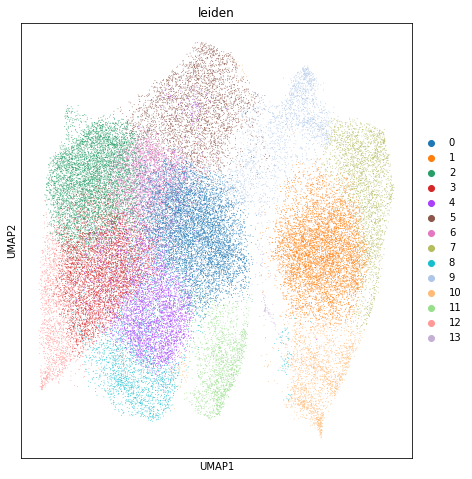

In [10]:
# SCANPY
sc.settings.verbosity = 4
adata = an.AnnData(cells.values.transpose())
adata.var_names = cells.index
adata.obs_names = cells.columns
bcs = np.loadtxt('allbcs.txt', dtype = str)
adata.obs['orig'] =[x.split('_')[0] for x in adata.obs_names]
adata.obs['bc']= bcs
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata
sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.filter_cells(adata, min_genes = 300)
print(adata)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata = process(adata)


In [14]:
adata.obs.head()

orig            bc  n_genes  n_counts leiden
S1_0   S1  AAAAACTCGCCA     1726    5800.0      1
S1_1   S1  AAAACACCTGTG     2307    7696.0     10
S1_2   S1  AAAACGGCTTAC      319     560.0      1
S1_3   S1  AAACTCGTCATG      370     954.0      1
S1_4   S1  AAAGGCCGCTTG     4684   25181.0     10

In [22]:
metadata = pd.read_csv('metadata.csv', index_col = 0)
adata.obs['location'] = [metadata.Location.loc[x] for x in adata.obs.orig]
adata.obs['condition'] = [metadata.Condition.loc[x] for x in adata.obs.orig]


... storing 'location' as categorical
... storing 'condition' as categorical


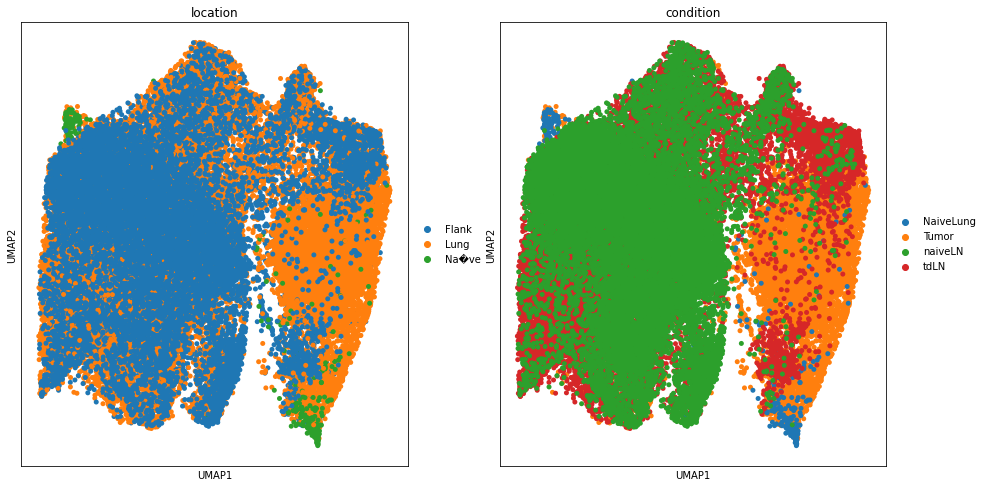

In [24]:
sc.pl.umap(adata, size = 100, color = ['location', 'condition'])

In [94]:
df[df.LogFC > 0].head(60)

LogFC      pct1      pct2           pval
Gene                                                
ITGA4    0.920696  0.397473  0.146316  4.865551e-128
NT5E     0.665226  0.245831  0.124211   4.806823e-75
RGS2     0.633882  0.350964  0.248421   9.039089e-47
NKG7     0.525226  0.287520  0.169474   1.625825e-41
RPLP0    0.374362  0.929260  0.842105   1.878872e-39
ACTB     0.250986  0.998697  0.993684   4.698101e-37
COTL1    0.468832  0.742314  0.635789   2.564724e-35
SKIL     0.486022  0.329208  0.275789   5.085421e-33
VPS37B   0.506276  0.241793  0.204211   1.852174e-32
IL10     0.409226  0.177566  0.106316   2.584274e-29
RGS16    0.366538  0.142783  0.091579   5.037459e-29
PDCD1    0.379058  0.258338  0.194737   2.411878e-22
CTSB     0.421116  0.562533  0.502105   4.452861e-22
ANGPTL2  0.295989  0.151641  0.103158   5.188371e-19
GSTO1    0.276434  0.120896  0.112632   8.708027e-19
RPS5     0.257279  0.840021  0.767368   2.056100e-17
TUBB5    0.251967  0.738275  0.677895   6.450263e-17
CXCR3    0.326877  0.232152  0.227368   2.486404e-12
ADAM19   0.345263  0.319567  0.326316   4.426091e-12
MCM6     0.286711  0.462871  0.450526   7.084339e-11
SEPT11   0.306199  0.396691  0.386316   9.643034e-11
NRP1     0.311482  0.214565  0.192632   1.077258e-10
ETS2     0.257101  0.203752  0.224211   1.747719e-10
RRM1     0.262293  0.384054  0.347368   3.189312e-10
CPD      0.263125  0.209093  0.208421   9.132674e-10
PRKCH    0.317686  0.371548  0.394737   1.474505e-08
IER2     0.281664  0.176915  0.220000   1.685646e-08
DUSP4    0.302332  0.349401  0.361053   2.145827e-08
LCLAT1   0.267101  0.185383  0.216842   2.504496e-08
DNAJB1   0.283839  0.229937  0.278947   6.536616e-08
SKI      0.307701  0.199583  0.258947   1.575526e-07
ITGB1    0.261822  0.358520  0.372632   4.050425e-07
CNN2     0.266524  0.547681  0.556842   1.897468e-06
INPP4B   0.287459  0.289604  0.342105   4.864857e-06
FLNA     0.261099  0.544294  0.560000   5.345295e-06
HSPA1A   0.261189  0.123111  0.125263   1.141461e-05
IPCEF1   0.275364  0.244528  0.285263   1.734048e-05
NAB1     0.295318  0.321391  0.364211   1.894174e-05
UBC      0.253138  0.351485  0.418947   4.649960e-04

In [91]:
df = diffgenes(adata, ['S2'], ['S1'], field = 'orig').sort_values(by = 'pval')
df.head(60)

LogFC      pct1      pct2           pval
Gene                                                 
ITGA4     0.920696  0.397473  0.146316  4.865551e-128
NT5E      0.665226  0.245831  0.124211   4.806823e-75
LY6A     -0.744827  0.497004  0.736842   7.645545e-69
TNFRSF9  -0.788474  0.318525  0.618947   6.056571e-61
CCR2     -0.935824  0.259380  0.558947   4.150101e-60
IL2RA    -0.729642  0.521365  0.734737   5.950505e-57
HIF1A    -0.562944  0.525925  0.732632   1.031659e-52
SATB1    -0.680602  0.091584  0.402105   1.202091e-48
RGS2      0.633882  0.350964  0.248421   9.039089e-47
RPL39    -0.527537  0.436816  0.658947   1.285925e-45
NABP1    -0.601661  0.177436  0.458947   6.840404e-43
NKG7      0.525226  0.287520  0.169474   1.625825e-41
LTB      -0.563185  0.251303  0.514737   1.084851e-40
GLRX     -0.561504  0.218082  0.476842   2.217586e-40
RPLP0     0.374362  0.929260  0.842105   1.878872e-39
GBP4     -0.576310  0.192678  0.469474   8.901343e-38
GZMB     -0.756333  0.334158  0.566316   1.567797e-37
ACTB      0.250986  0.998697  0.993684   4.698101e-37
PTMA     -0.467335  0.644085  0.807368   7.065783e-37
IGTP     -0.575243  0.286217  0.534737   1.110269e-36
ICOS     -0.526053  0.566180  0.732632   1.643288e-36
IL7R     -0.663158  0.120505  0.384211   9.963291e-36
NEAT1    -0.532641  0.086503  0.355789   1.132212e-35
SERINC3  -0.535363  0.469385  0.651579   1.132418e-35
COTL1     0.468832  0.742314  0.635789   2.564724e-35
GBP6     -0.521468  0.113210  0.380000   1.854730e-33
SKIL      0.486022  0.329208  0.275789   5.085421e-33
KLRG1    -0.595152  0.192678  0.444211   5.877981e-33
GBP7     -0.490105  0.333246  0.552632   1.630315e-32
VPS37B    0.506276  0.241793  0.204211   1.852174e-32
RPL38    -0.404613  0.338718  0.556842   4.060782e-32
EMB      -0.537060  0.106957  0.337895   1.128639e-31
RPS28    -0.446879  0.324779  0.540000   2.946524e-31
IFI27L2A -0.551334  0.416232  0.613684   3.053502e-30
IL2RG    -0.414216  0.278661  0.505263   3.995308e-30
IL10      0.409226  0.177566  0.106316   2.584274e-29
RGS16     0.366538  0.142783  0.091579   5.037459e-29
IIGP1    -0.743250  0.085201  0.278947   1.395774e-28
B2M      -0.498777  0.739838  0.812632   1.977371e-28
DGAT1    -0.413720  0.178088  0.430526   3.060401e-28
WLS      -0.414826  0.053413  0.272632   4.883648e-28
CAST     -0.399367  0.265894  0.498947   5.019113e-28
TMSB10   -0.424099  0.542861  0.686316   1.504055e-27
RPL23A   -0.425136  0.466649  0.638947   2.625777e-27
ITGB3    -0.433528  0.099401  0.322105   3.845843e-27
RN7SK    -0.397650  0.108781  0.345263   1.910992e-26
TPI1     -0.495252  0.333637  0.535789   2.512404e-26
ZFP36L1  -0.435835  0.213132  0.435789   4.594799e-26
ST8SIA4  -0.428155  0.166363  0.388421   1.125931e-25
CLEC2D   -0.333057  0.220427  0.454737   1.160036e-25
IL1R2    -0.472362  0.048463  0.240000   2.120872e-25
LY6E     -0.427708  0.559927  0.683158   4.518847e-25
ITM2C    -0.375044  0.238015  0.464211   4.883319e-25
PGLYRP1  -0.294038  0.115555  0.341053   1.583969e-24
COX17    -0.297768  0.131579  0.353684   1.600846e-24
RNASET2A -0.305267  0.119724  0.363158   3.348502e-24
WNK1     -0.367109  0.502215  0.662105   3.386399e-24
NDRG1    -0.386777  0.090933  0.316842   5.285176e-24
FYB      -0.306054  0.319177  0.540000   6.829747e-24
PTPN18   -0.311192  0.217301  0.449474   1.530106e-23

In [35]:
df.head(60)

LogFC      pct1      pct2           pval
Gene                                                 
ITGA4     0.920696  0.397473  0.146316  4.865551e-128
NT5E      0.665226  0.245831  0.124211   4.806823e-75
RGS2      0.633882  0.350964  0.248421   9.039089e-47
NKG7      0.525226  0.287520  0.169474   1.625825e-41
VPS37B    0.506276  0.241793  0.204211   1.852174e-32
SKIL      0.486022  0.329208  0.275789   5.085421e-33
COTL1     0.468832  0.742314  0.635789   2.564724e-35
CTSB      0.421116  0.562533  0.502105   4.452861e-22
IL10      0.409226  0.177566  0.106316   2.584274e-29
PDCD1     0.379058  0.258338  0.194737   2.411878e-22
RPLP0     0.374362  0.929260  0.842105   1.878872e-39
RGS16     0.366538  0.142783  0.091579   5.037459e-29
ADAM19    0.345263  0.319567  0.326316   4.426091e-12
CXCR3     0.326877  0.232152  0.227368   2.486404e-12
PRKCH     0.317686  0.371548  0.394737   1.474505e-08
NRP1      0.311482  0.214565  0.192632   1.077258e-10
SKI       0.307701  0.199583  0.258947   1.575526e-07
SEPT11    0.306199  0.396691  0.386316   9.643034e-11
DUSP4     0.302332  0.349401  0.361053   2.145827e-08
ANGPTL2   0.295989  0.151641  0.103158   5.188371e-19
NAB1      0.295318  0.321391  0.364211   1.894174e-05
INPP4B    0.287459  0.289604  0.342105   4.864857e-06
MCM6      0.286711  0.462871  0.450526   7.084339e-11
DNAJB1    0.283839  0.229937  0.278947   6.536616e-08
IER2      0.281664  0.176915  0.220000   1.685646e-08
GSTO1     0.276434  0.120896  0.112632   8.708027e-19
IPCEF1    0.275364  0.244528  0.285263   1.734048e-05
LCLAT1    0.267101  0.185383  0.216842   2.504496e-08
CNN2      0.266524  0.547681  0.556842   1.897468e-06
CPD       0.263125  0.209093  0.208421   9.132674e-10
RRM1      0.262293  0.384054  0.347368   3.189312e-10
ITGB1     0.261822  0.358520  0.372632   4.050425e-07
HSPA1A    0.261189  0.123111  0.125263   1.141461e-05
FLNA      0.261099  0.544294  0.560000   5.345295e-06
RPS5      0.257279  0.840021  0.767368   2.056100e-17
ETS2      0.257101  0.203752  0.224211   1.747719e-10
UBC       0.253138  0.351485  0.418947   4.649960e-04
TUBB5     0.251967  0.738275  0.677895   6.450263e-17
ACTB      0.250986  0.998697  0.993684   4.698101e-37
TRIM30A  -0.250272  0.158676  0.350526   5.885153e-14
TAP1     -0.250578  0.410240  0.580000   7.138468e-17
D4WSU53E -0.250784  0.243877  0.450526   5.400569e-17
KMT2A    -0.253478  0.224726  0.420000   5.521892e-16
SH3BGRL  -0.254251  0.242965  0.415789   1.374499e-13
PTBP3    -0.254466  0.354351  0.520000   1.626998e-14
TM9SF2   -0.254834  0.114122  0.316842   2.176750e-16
SSB      -0.255751  0.281657  0.467368   1.594179e-12
PFKL     -0.256637  0.116858  0.308421   1.949287e-15
EIF2S2   -0.257013  0.175482  0.338947   2.206403e-11
OSTF1    -0.257713  0.183950  0.369474   1.930994e-14
HMGB1    -0.257873  0.242183  0.422105   9.315491e-13
NCOA7    -0.257918  0.078817  0.243158   3.076362e-15
LFNG     -0.258224  0.107999  0.321053   2.473268e-19
BMP2K    -0.259855  0.139917  0.340000   3.772017e-17
EDEM1    -0.262169  0.196717  0.414737   2.172586e-18
SELPLG   -0.262642  0.338848  0.520000   3.305393e-18
SLC2A3   -0.262669  0.056279  0.250526   2.339518e-22
CCR3     -0.263981  0.031657  0.104211   2.025299e-08
RPL36    -0.264883  0.249479  0.454737   1.939512e-17
RPL36A   -0.266643  0.296248  0.466316   1.187617e-13

In [89]:
df = diffgenes(adata, ['S4', 'S5'], ['S8', 'S9'], field = 'orig', threshold = .1).sort_values(by = 'pval')
df.head(60)

LogFC      pct1      pct2           pval
Gene                                                     
STAT1         0.868825  0.777444  0.523171   0.000000e+00
IGTP          0.818286  0.461484  0.227048   0.000000e+00
GBP2          0.842605  0.323078  0.141795  1.163864e-264
RNF213        0.741520  0.469155  0.289274  7.496996e-217
GBP6          0.632707  0.255536  0.103468  5.110229e-207
IFI47         0.603268  0.422809  0.247158  1.391404e-199
SAMHD1        0.561741  0.730781  0.590644  2.692691e-197
IIGP1         0.619248  0.207608  0.075197  9.312131e-182
ZBP1          0.553161  0.265264  0.127222  1.849176e-162
GBP7          0.572689  0.366419  0.218449  3.554957e-154
IRF1          0.548174  0.385005  0.230691  6.387238e-152
GBP4          0.564177  0.290256  0.159283  4.197311e-143
GBP10         0.407985  0.107086  0.025940  7.247855e-134
GM23935      -0.225950  0.934910  0.971583  4.105251e-120
DTX3L         0.476627  0.337077  0.209560  5.431619e-117
IRGM2         0.448541  0.173126  0.073594  3.383026e-115
LY6A          0.473488  0.190683  0.084815  2.605794e-113
IFI27L2A      0.455373  0.507672  0.387788  2.215535e-110
GIMAP4        0.381674  0.593088  0.467939  4.256216e-105
GM14446       0.439387  0.150111  0.064850  1.136868e-101
B2M           0.265470  0.853290  0.759691  1.545368e-101
IRGM1         0.415588  0.169171  0.078257  2.676506e-100
TAP1          0.386803  0.467099  0.342757   7.523497e-98
ISG15         0.380666  0.111515  0.037598   1.137098e-96
MMU-MIR-6236 -0.199903  0.998576  0.999563   2.596281e-96
GBP3          0.392168  0.223663  0.118333   7.315903e-91
STAT2         0.433671  0.200332  0.107257   2.341205e-89
MALAT1       -0.287632  0.881525  0.927135   1.209616e-87
PARP14        0.424693  0.325846  0.219178   6.771248e-83
PSMB8         0.326866  0.653037  0.564267   8.776742e-80
PARP9         0.366153  0.197643  0.107112   2.041362e-78
IRF7          0.343901  0.118317  0.049840   6.203354e-76
PYHIN1        0.384054  0.286381  0.191344   3.129091e-72
GBP9          0.373209  0.188073  0.108423   3.519426e-71
GM4955        0.382161  0.180481  0.101282   4.175038e-70
BST2          0.328268  0.154777  0.080880   3.245377e-68
ACTB          0.137132  0.994701  0.988925   1.839784e-64
SELL          0.309717  0.615391  0.525503   2.462326e-63
GBP5          0.345667  0.181984  0.104780   4.178661e-63
MKI67         0.486823  0.141490  0.069805   1.721359e-62
TAPBP         0.317757  0.487741  0.395366   1.798408e-62
HSPA8         0.293795  0.692502  0.627077   8.219227e-60
PSMB10        0.325661  0.328614  0.238269   1.246156e-58
IFI203        0.341030  0.330196  0.242932   2.186570e-58
PSME1         0.304993  0.513129  0.429029   2.458546e-56
NAMPT         0.286373  0.151930  0.083941   1.507184e-55
GIMAP7        0.295653  0.182300  0.113669   1.592766e-50
TRIM30A       0.316691  0.215201  0.143836   1.275859e-48
PSMB9         0.281453  0.253559  0.176042   1.863977e-48
SLFN1         0.323070  0.250554  0.181288   1.375944e-47
FOS          -0.272823  0.073553  0.146896   3.226401e-46
MS4A4B        0.303856  0.481968  0.408044   2.225872e-45
HMGB2         0.317522  0.168618  0.108277   4.201792e-45
TRIM12C       0.279111  0.151297  0.091956   4.463126e-45
LGALS3BP      0.256171  0.139196  0.077820   6.803861e-45
MT-RNR2      -0.126276  1.000000  1.000000   1.425071e-44
SLFN8         0.301523  0.220104  0.152142   1.579930e-44
TOP2A         0.370613  0.131683  0.073885   2.148649e-42
GM26917      -0.195191  0.489798  0.590207   3.337279e-42
H2-T24        0.262435  0.116735  0.066453   6.820223e-41

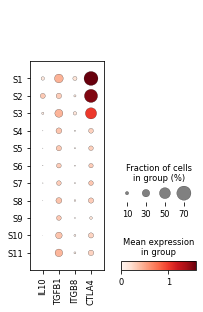

In [43]:
sc.pl.dotplot(adata, var_names = ['IL10', 'TGFB1', 'ITGB8', 'CTLA4'], groupby = 'orig')

extracting highly variable genes
    Gene indices [904, 5782, 6051, 7614, 8406] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
regressing out n_counts
    finished (0:00:45)
computing PCA
    with n_comps=50


linear scaling


    finished (0:00:02)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:01)
    computed connectivities (0:00:01)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:38)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


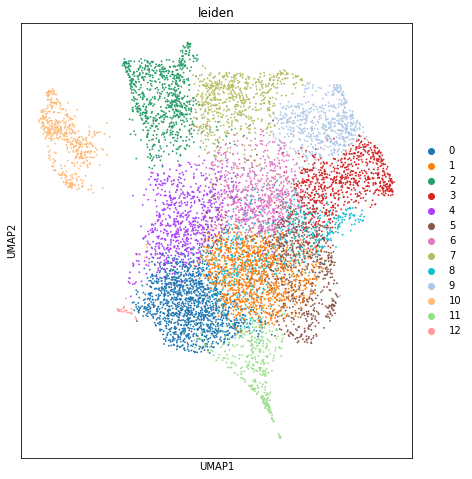

In [44]:
tumor = subprocess(adata, whichcells(adata, ['S1', 'S2', 'S3'], field = 'orig'))

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:12)


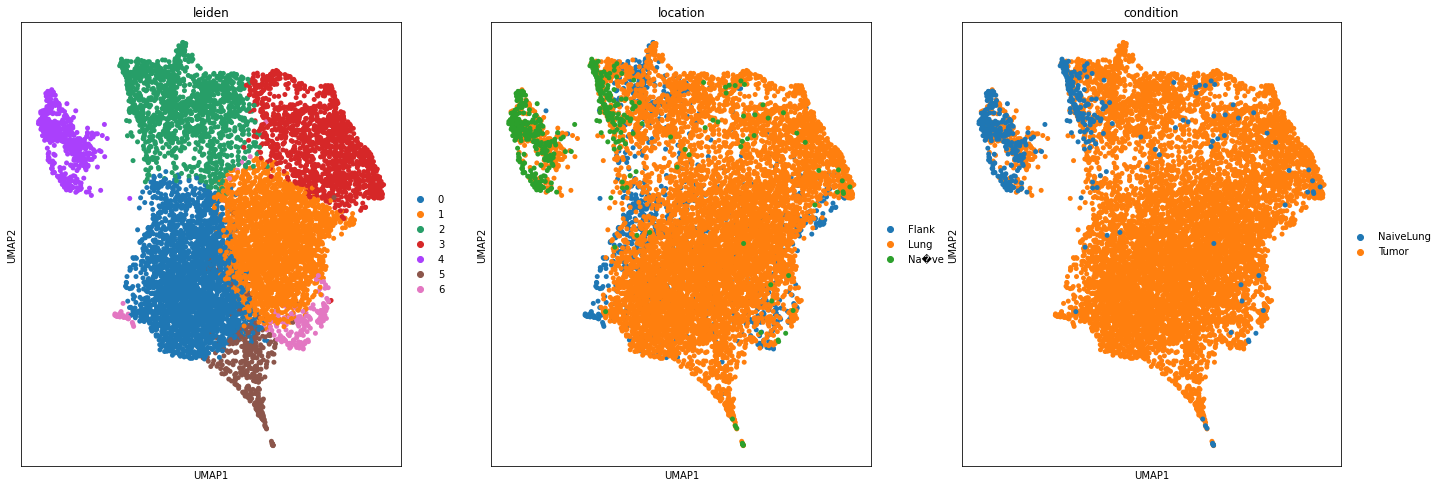

In [47]:
sc.tl.leiden(tumor, resolution = .5)
sc.pl.umap(tumor, size = 100, color = ['leiden', 'location', 'condition'])

extracting highly variable genes
    Gene indices [904, 5782, 6051, 7614, 8406] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
regressing out n_counts
    finished (0:00:50)
computing PCA
    with n_comps=50


linear scaling


    finished (0:00:02)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:01)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


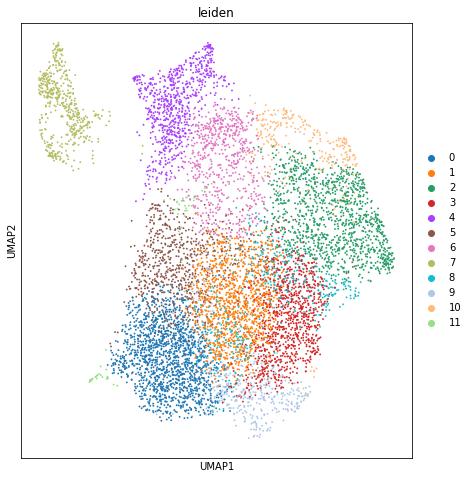

In [53]:
t2 = removecluster(tumor, ['5'])

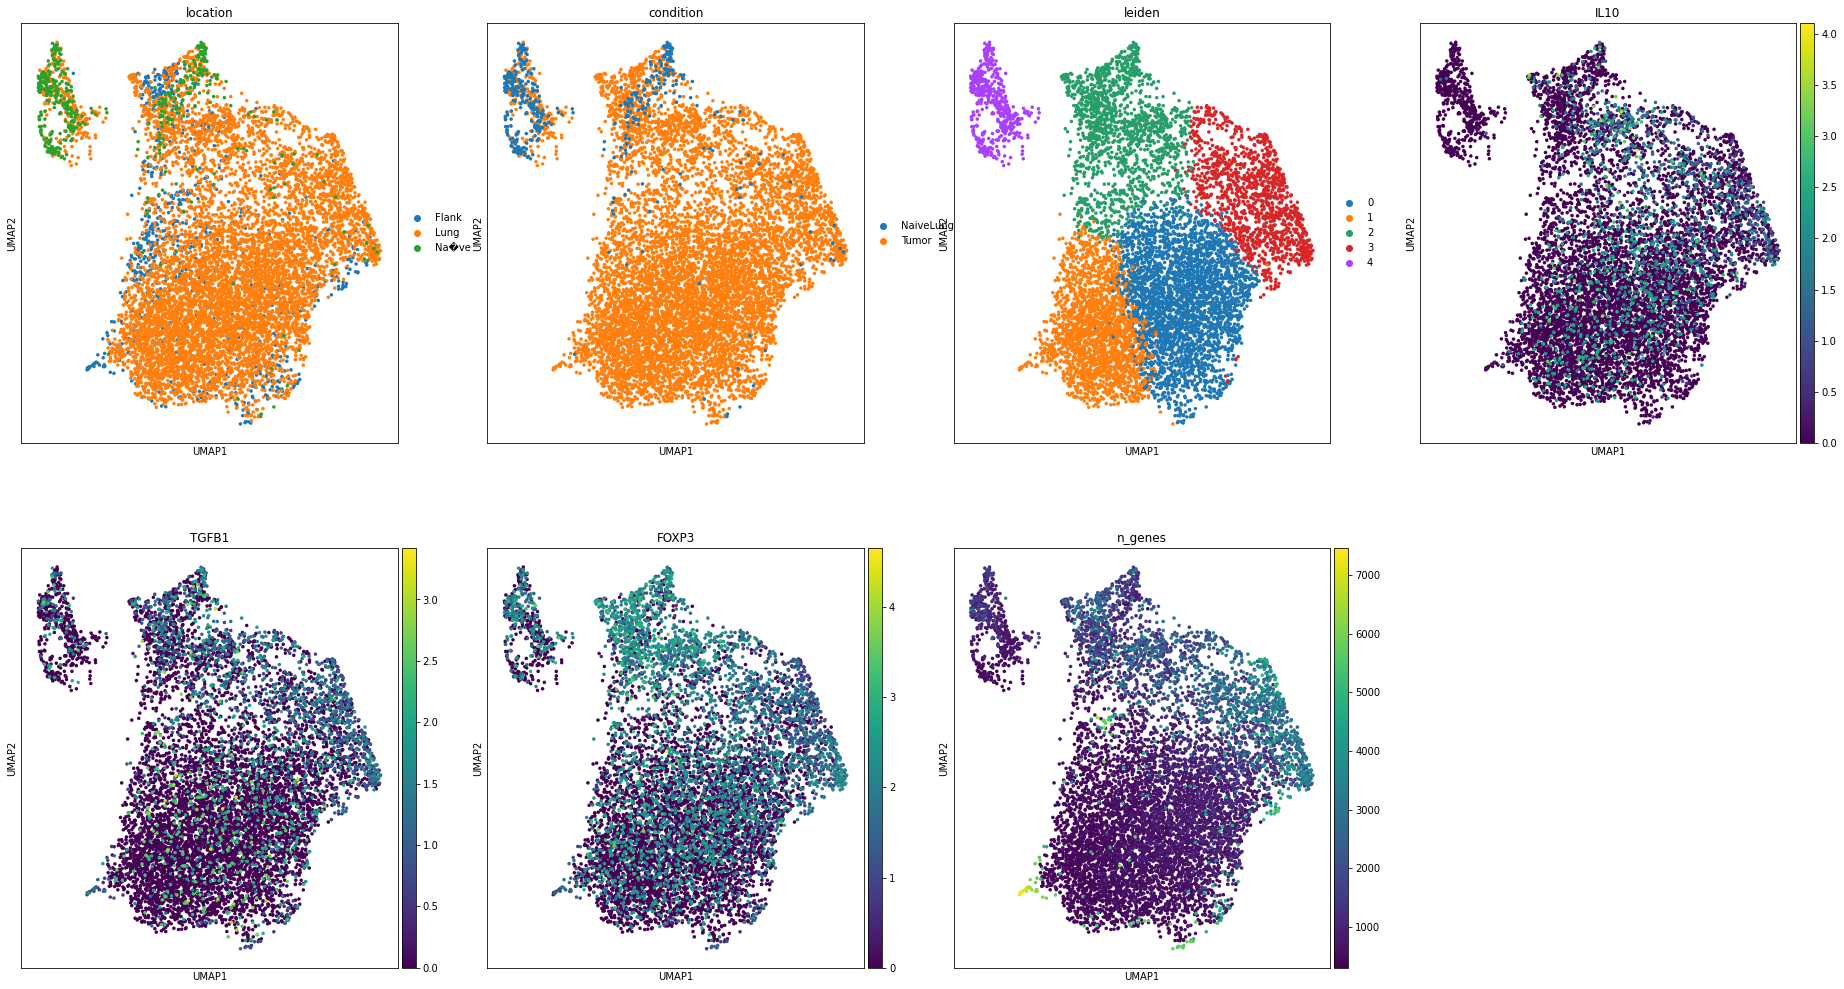

In [59]:
#sc.tl.leiden(t2, resolution = .4)
sc.pl.umap(t2, color = ['location', 'condition', 'leiden', 'IL10', 'TGFB1', 'FOXP3', 'n_genes'], size = 50)

extracting highly variable genes
    Gene indices [904, 6051, 7614, 8406, 8618, 8619] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
regressing out n_counts
    finished (0:00:22)
computing PCA
    with n_comps=50


linear scaling


    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


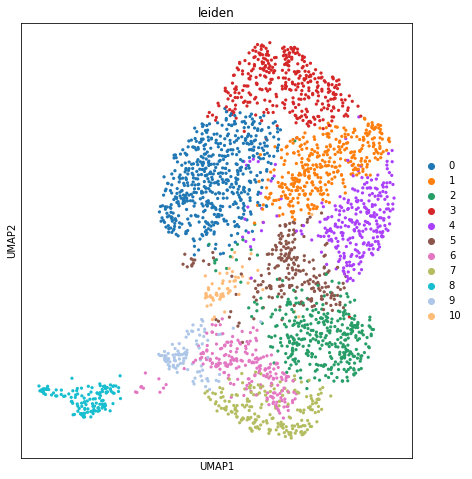

In [60]:
t3 = subprocess(t2, t2.obs_names[t2.obs.n_genes > 1000])

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


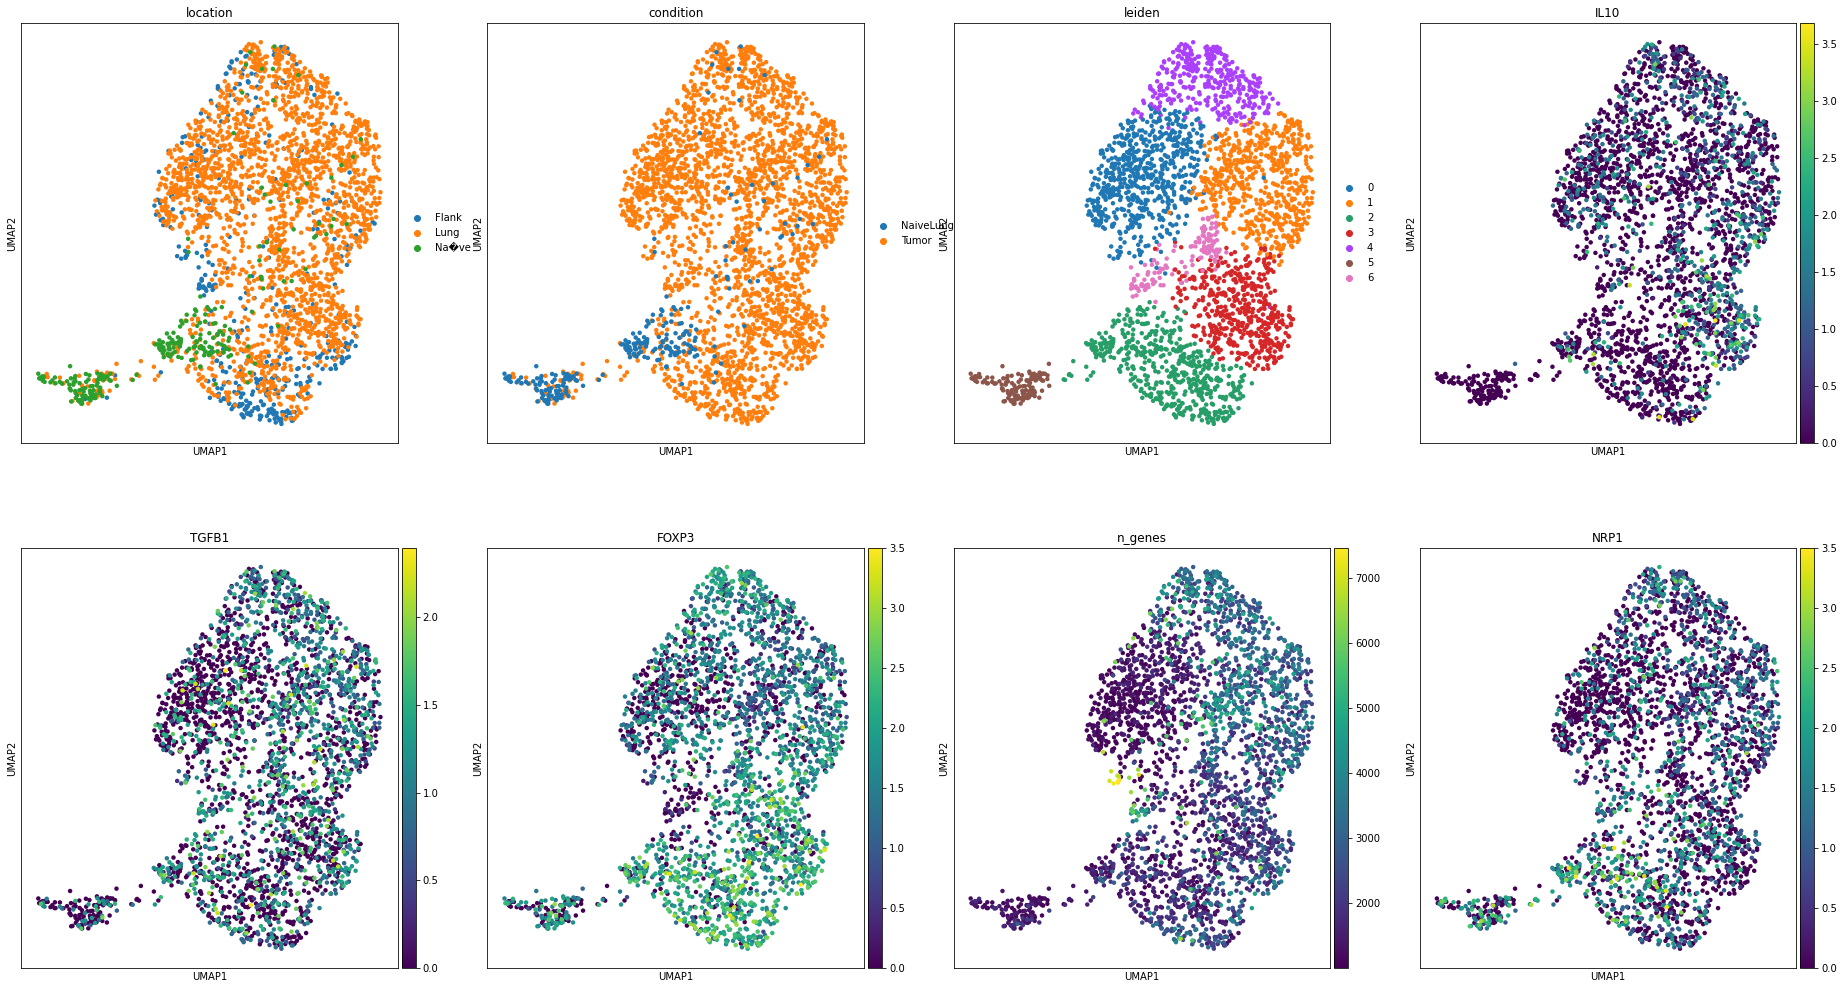

In [65]:
sc.tl.leiden(t3, resolution = .6)
sc.pl.umap(t3, color = ['location', 'condition', 'leiden', 'IL10', 'TGFB1', 'FOXP3', 'n_genes', 'NRP1'], size = 80)

In [70]:
def seuratExport(adata, fname):
    df = pd.DataFrame(adata.raw.X.transpose())
    df.columns = adata.obs_names
    df.index = adata.raw.var_names
    df = df.reset_index()
    pyarrow.feather.write_feather(df, fname + '.feather') 
    adata.obs.to_csv(fname + '_meta.txt')
    
    
seuratExport(t2, 'tissue_treg')

extracting highly variable genes
    Gene indices [5782, 6051, 8406] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:04)
regressing out n_counts
    finished (0:02:25)
computing PCA
    with n_comps=50


linear scaling


    finished (0:00:11)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:03)
    computed connectivities (0:00:04)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:08)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:54)


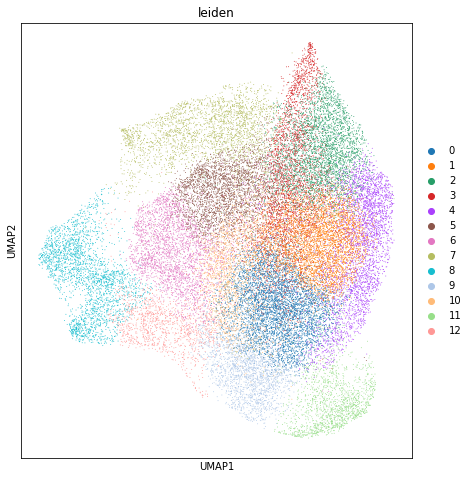

In [71]:
ln = removecluster(adata, ['S1', 'S2', 'S3'], field = 'orig')

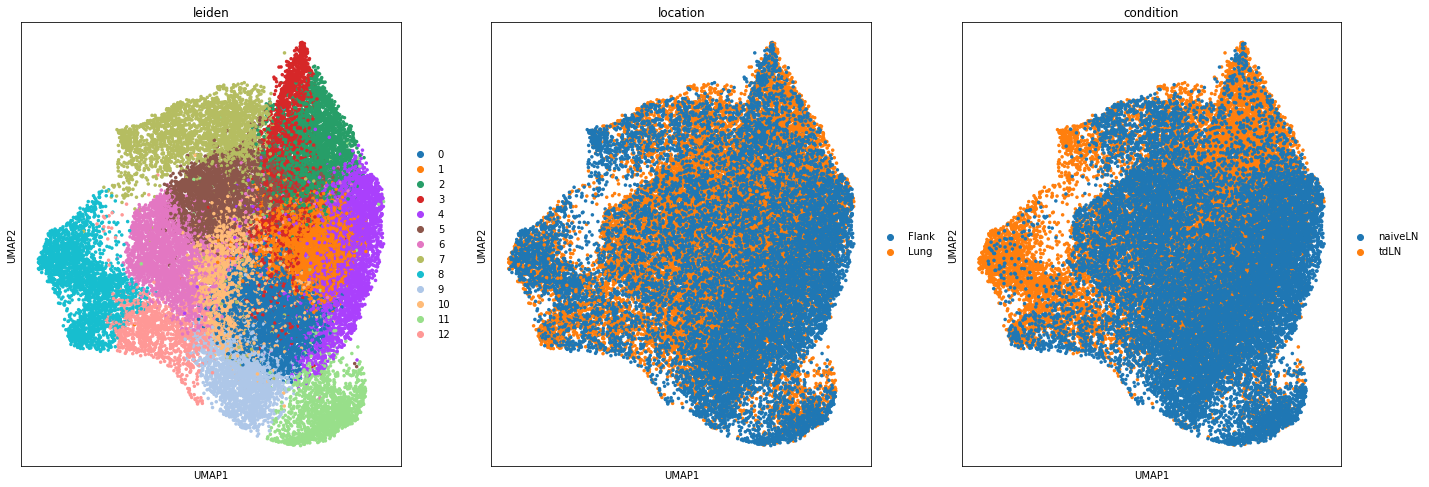

In [72]:
sc.pl.umap(ln, color = ['leiden', 'location', 'condition'], size = 50)

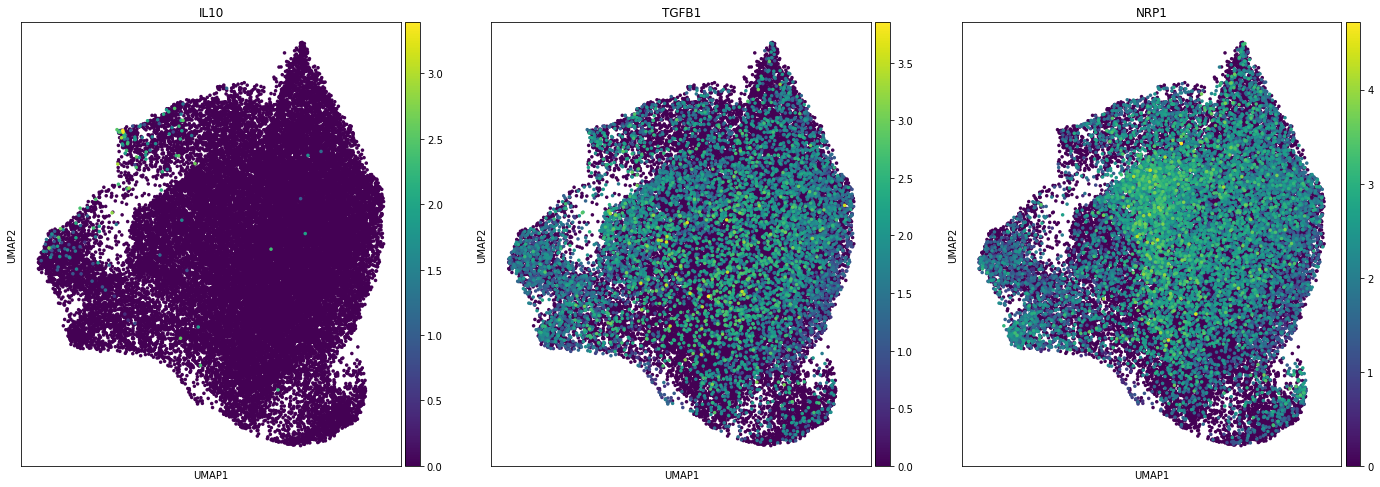

In [75]:
sc.pl.umap(ln, color = ['IL10', 'TGFB1', 'NRP1'], size = 50)

leiden         0         1         2         3         4         5         6  \
orig                                                                           
S4      0.085274  0.097561  0.187603  0.122501  0.051898  0.087658  0.082340   
S5      0.125296  0.122375  0.147824  0.136421  0.030177  0.089556  0.090113   
S6      0.145443  0.112360  0.083958  0.158864  0.010612  0.040886  0.099251   
S7      0.155116  0.090688  0.082837  0.162155  0.010287  0.038711  0.093124   
S8      0.109716  0.149199  0.040211  0.015102  0.094978  0.177402  0.093159   
S9      0.216691  0.112738  0.013909  0.016837  0.019766  0.076867  0.106881   
S10     0.146755  0.097980  0.037172  0.028363  0.180920  0.062312  0.065105   
S11     0.127096  0.084057  0.032128  0.039200  0.237826  0.056577  0.054961   

leiden         7         8         9        10        11        12  
orig                                                                
S4      0.066385  0.073354  0.019806  0.029892  0.025124  0.070603  
S5      0.067445  0.093589  0.020164  0.042275  0.014602  0.020164  
S6      0.106429  0.157303  0.019351  0.035581  0.008739  0.021223  
S7      0.105847  0.141310  0.024905  0.034651  0.011911  0.048457  
S8      0.075691  0.022198  0.057132  0.070597  0.067140  0.027475  
S9      0.057833  0.029283  0.120059  0.137628  0.016837  0.074671  
S10     0.064461  0.020413  0.119252  0.065320  0.079072  0.032875  
S11     0.056779  0.017983  0.117397  0.055971  0.095777  0.024247

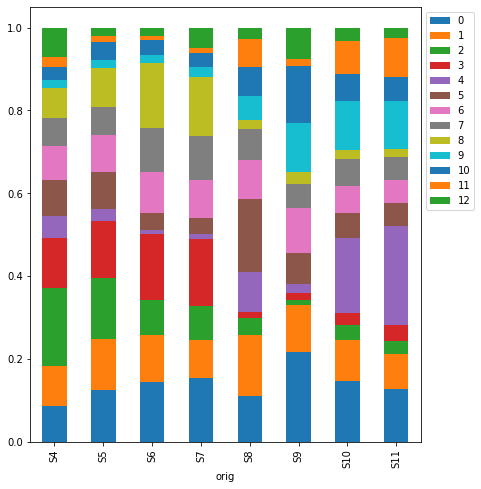

In [77]:
barplot(ln.obs, 'orig', 'leiden')

In [86]:
diffgenes(ln, ['LungtdLN2', 'LungtdLN3'], ['FlanktdLN2', 'FlanktdLN3'], field = 'both', threshold = .1).sort_values(by = 'pval').head(60)

LogFC      pct1      pct2          pval
Gene                                                
MT-RNR1   0.216911  1.000000  1.000000  4.070905e-81
MT-RNR2   0.203710  1.000000  1.000000  3.735789e-80
RPS28     0.334855  0.394913  0.183601  1.993080e-41
RPS27     0.333903  0.575100  0.352941  2.183348e-41
RPL39     0.342977  0.440161  0.232323  2.136490e-39
SKIL      0.366963  0.317537  0.140820  7.569248e-37
RPLP1     0.226636  0.831325  0.660725  7.386524e-34
RPS20     0.233279  0.827577  0.668449  1.888964e-31
NRP1      0.388110  0.288086  0.135472  1.664953e-30
RPL26     0.219134  0.691299  0.494355  1.744268e-30
APOL9B    0.333383  0.120750  0.030897  1.554596e-29
RPS13     0.216820  0.691566  0.495544  4.495861e-29
CTSW      0.315467  0.170549  0.058229  2.190426e-27
TMSB4X    0.163949  0.918072  0.804516  3.881012e-27
RGS10     0.265069  0.377242  0.202020  5.455570e-27
RPLP2     0.200609  0.652209  0.457516  9.047898e-27
RPL38     0.255147  0.350201  0.177065  9.474950e-27
RPS21     0.186701  0.731727  0.550208  3.318981e-26
HSP90AB1  0.170623  0.841767  0.685086  5.994960e-26
RPS19     0.200204  0.699063  0.519311  6.335020e-25
RPL37     0.225244  0.426774  0.247772  7.891192e-25
RPL23A    0.210432  0.512182  0.327392  3.071831e-24
CD52      0.239522  0.402677  0.229352  3.594243e-24
FXYD5     0.240274  0.364926  0.198455  2.544048e-23
SKI       0.260383  0.323159  0.168746  8.161924e-23
RPS29     0.206093  0.455957  0.277481  1.858294e-22
RPS26     0.159103  0.666934  0.483660  2.162318e-22
RN7SK     0.292589  0.187952  0.080214  2.017118e-21
RPL30     0.131593  0.699866  0.519905  7.086001e-21
B2M       0.120627  0.896653  0.780154  4.940936e-20
KLF2      0.234474  0.275770  0.140820  2.621690e-19
SMAD7     0.214411  0.201071  0.089127  3.047921e-18
LAPTM5    0.122708  0.693976  0.529412  6.604506e-18
TREML2    0.173007  0.408300  0.249554  9.196479e-18
PTPN18    0.195697  0.256760  0.132501  1.208106e-16
RPL37A    0.151808  0.442035  0.282828  1.547893e-16
RPS10     0.131302  0.535207  0.370766  2.310525e-16
MACF1     0.121093  0.778581  0.639929  2.729706e-16
CRIP1     0.221103  0.225703  0.114082  4.154239e-16
CTSS      0.151317  0.466667  0.307190  4.207997e-16
HSPH1     0.214537  0.173762  0.076649  4.370290e-16
PIK3R1    0.193801  0.334404  0.198455  8.034862e-16
DDIT4     0.216584  0.192771  0.093880  1.011349e-15
ACP5      0.192262  0.185542  0.085561  2.280521e-15
SPTBN1    0.108814  0.515930  0.351753  4.468262e-15
HSP90AA1  0.187204  0.269880  0.147356  4.541309e-15
RASAL3    0.157981  0.357430  0.214498  7.588923e-15
IGF2R     0.148822  0.417671  0.269756  9.977267e-15
LCK       0.110694  0.515663  0.360665  9.987426e-14
RPL22     0.151262  0.366533  0.231729  1.220686e-13
KMT2C     0.208666  0.324230  0.203209  1.346953e-13
IGFBP4    0.272571  0.188755  0.099822  2.211563e-13
EMP3      0.197110  0.149398  0.068330  2.295482e-13
DNAJB1    0.187050  0.159572  0.073084  2.955662e-13
MT-ND4    0.108825  0.405890  0.261438  1.143229e-12
FMNL3     0.185380  0.119143  0.048723  1.442063e-12
MLLT3     0.169213  0.214726  0.114082  1.637887e-12
RPL27A    0.139313  0.318876  0.195484  1.779759e-12
RGS1      0.177652  0.301473  0.183007  2.040572e-12
RBM39     0.112124  0.446051  0.297683  2.268781e-12

In [82]:
seuratExport(ln, 'treg_ln')

In [84]:
ln.obs['both'] = [ln.obs.location.loc[x] + ln.obs.condition.loc[x] + ln.obs.leiden.loc[x] for x in ln.obs_names]
Counter(ln.obs.both)

Counter({'LungtdLN6': 1097,
         'LungtdLN3': 1649,
         'LungtdLN8': 1073,
         'LungtdLN5': 1122,
         'LungtdLN2': 2086,
         'LungtdLN7': 847,
         'LungtdLN10': 467,
         'LungtdLN0': 1366,
         'LungtdLN12': 530,
         'LungtdLN11': 242,
         'LungtdLN1': 1412,
         'LungtdLN4': 500,
         'LungtdLN9': 253,
         'FlanktdLN8': 1026,
         'FlanktdLN3': 1108,
         'FlanktdLN0': 1039,
         'FlanktdLN2': 575,
         'FlanktdLN1': 695,
         'FlanktdLN6': 662,
         'FlanktdLN4': 72,
         'FlanktdLN10': 242,
         'FlanktdLN12': 247,
         'FlanktdLN5': 274,
         'FlanktdLN7': 732,
         'FlanktdLN11': 72,
         'FlanktdLN9': 154,
         'LungnaiveLN8': 162,
         'LungnaiveLN0': 899,
         'LungnaiveLN6': 658,
         'LungnaiveLN1': 974,
         'LungnaiveLN10': 576,
         'LungnaiveLN11': 392,
         'LungnaiveLN5': 1080,
         'LungnaiveLN4': 549,
         'LungnaiveLN9': 478

In [78]:
ln

AnnData object with n_obs × n_vars = 36007 × 1697
    obs: 'orig', 'bc', 'n_genes', 'n_counts', 'leiden', 'location', 'condition'
    var: 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'location_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [81]:
getgenes(ln, ['7']).head(60)

LogFC      pct1      pct2           pval       pval_adj
Gene                                                                 
ICOS       1.474702  0.524294  0.132526  4.091731e-274  9.329148e-272
MAF        1.447412  0.526554  0.074748   0.000000e+00   0.000000e+00
GBP2B      1.348570  0.296045  0.012143  4.166348e-178  9.499273e-176
S100A4     1.335952  0.353296  0.035020  8.135116e-198  1.854806e-195
ITGAE      1.239723  0.412053  0.079485  5.529980e-209  1.260835e-206
AHNAK      1.236747  0.774765  0.322949   0.000000e+00   0.000000e+00
IGHM       1.075700  0.609793  0.238756  1.155546e-267  2.634645e-265
CCR4       1.044409  0.323917  0.038019  6.213953e-176  1.416781e-173
LY6A       1.017284  0.427119  0.141221  3.329810e-166  7.591966e-164
CCR2       0.996960  0.194727  0.013432  1.880168e-104  4.286782e-102
NEB        0.900985  0.250094  0.065603   4.808435e-95   1.096323e-92
ARL5A      0.882540  0.339360  0.136394  1.473628e-111  3.359872e-109
S100A6     0.772683  0.225989  0.040777   1.723678e-99   3.929987e-97
CTLA4      0.733238  0.345386  0.154983   3.468753e-95   7.908757e-93
FAM129A    0.724660  0.354049  0.158101   2.131837e-98   4.860589e-96
TNFRSF1B   0.715669  0.346516  0.175372   9.142512e-87   2.084493e-84
SRGN       0.700582  0.571751  0.326757  1.610247e-137  3.671363e-135
FGL2       0.676933  0.174388  0.020179   1.394708e-84   3.179934e-82
TIMP2      0.667235  0.274953  0.083173   2.436614e-97   5.555481e-95
ITM2B      0.663835  0.728437  0.541947  3.540274e-146  8.071824e-144
IL18R1     0.663199  0.205273  0.052591   6.946612e-77   1.583828e-74
MATK       0.651894  0.188701  0.030133   8.569524e-84   1.953852e-81
GBP3       0.608353  0.374011  0.168476   2.939249e-96   6.701487e-94
IKZF3      0.596981  0.424859  0.232820   4.725781e-93   1.077478e-90
SERINC3    0.593827  0.451601  0.250959   5.488802e-98   1.251447e-95
S100A10    0.589669  0.523164  0.315423  2.137492e-107  4.873482e-105
NT5E       0.577317  0.340113  0.169555   1.227573e-74   2.798866e-72
CAPG       0.572482  0.601507  0.394159  6.480723e-117  1.477605e-114
AW112010   0.572208  0.331827  0.158791   5.713295e-79   1.302631e-76
MALT1      0.565508  0.264407  0.113606   2.277089e-68   5.191763e-66
TIGIT      0.563491  0.146893  0.033521   2.326524e-57   5.304474e-55
IFNGR1     0.542156  0.366855  0.191863   1.269952e-76   2.895489e-74
IL7R       0.529096  0.258380  0.125030   1.355282e-54   3.090044e-52
N4BP1      0.528302  0.241808  0.090819   4.136956e-68   9.432260e-66
SLA        0.523931  0.376271  0.222026   2.408540e-65   5.491471e-63
PRG4       0.518565  0.138983  0.031752   2.529612e-51   5.767514e-49
VPS54      0.511202  0.320151  0.152974   1.438237e-72   3.279180e-70
TMEM66     0.510501  0.431638  0.245203   5.275367e-82   1.202784e-79
IGTP       0.509592  0.522787  0.338391   3.551708e-80   8.097893e-78
MYO1F      0.504032  0.157439  0.023987   4.351420e-71   9.921238e-69
TRP53INP1  0.489223  0.442938  0.265531   1.257393e-73   2.866856e-71
FAM46C     0.481952  0.233145  0.105061   1.169859e-54   2.667279e-52
SERPINA3G  0.478828  0.120151  0.027914   2.009028e-46   4.580585e-44
ITGB1      0.477751  0.344256  0.202597   1.455492e-53   3.318522e-51
PSEN2      0.473504  0.265913  0.120742   2.461953e-62   5.613252e-60
UBL3       0.472714  0.287759  0.149976   1.061153e-57   2.419429e-55
ATP2B1     0.472350  0.321657  0.169975   6.474547e-63   1.476197e-60
IIGP1      0.470848  0.251224  0.129677   6.096675e-44   1.390042e-41
ANGPTL2    0.469518  0.103578  0.024496   1.641923e-37   3.743584e-35
LRBA       0.467161  0.267043  0.146228   7.657661e-48   1.745947e-45
GM2A       0.461187  0.335217  0.197290   7.236271e-55   1.649870e-52
LGALS1     0.459354  0.400377  0.257616   2.783980e-50   6.347475e-48
TMEM154    0.458765  0.205650  0.091779   1.557468e-49   3.551027e-47
PDE2A      0.453809  0.159322  0.044285   4.808494e-52   1.096337e-49
GLRX       0.448426  0.144256  0.035050   7.474947e-55   1.704288e-52
THY1       0.448302  0.5

leiden         0         1         2         3         4         5         6
orig                                                                        
S1      0.373684  0.206316  0.256842  0.064211  0.006316  0.006316  0.086316
S2      0.306540  0.306931  0.129755  0.167014  0.031136  0.044685  0.013940
S3      0.021053  0.006316  0.343158  0.052632  0.547368  0.016842  0.012632

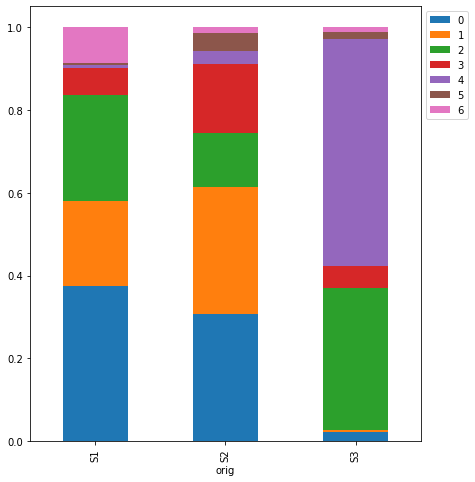

In [48]:
barplot(tumor.obs, 'orig', 'leiden')

In [24]:
adata.obs['UMAP1'] = adata.obsm['X_umap'][:,0]
adata.obs['UMAP2'] = adata.obsm['X_umap'][:,1]

In [25]:
import pyarrow.feather
def seuratExport(adata, fname):
    df = pd.DataFrame(adata.raw.X.transpose())
    df.columns = adata.obs_names
    df.index = adata.raw.var_names
    df = df.reset_index()
    pyarrow.feather.write_feather(df, fname + '.feather') 
    adata.obs.to_csv(fname + '_meta.txt')
    
seuratExport(adata, 'F_rhesus')

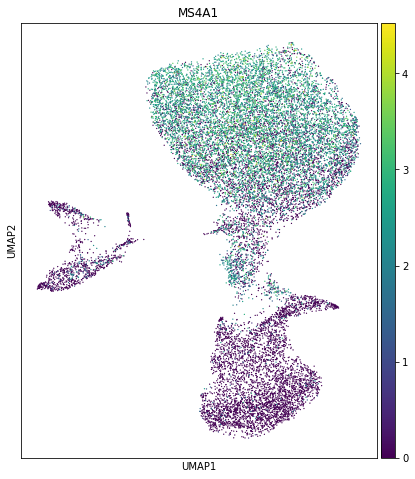

In [26]:
sc.pl.umap(adata, color = 'MS4A1')

In [19]:
df = pd.read_csv('210902Lov/file_igblast_db-pass.tab', index_col = 0, sep = '\t')
df.head()

SEQUENCE_INPUT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  GGGGGGGGGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   
GATTTGTAAGTTATCTTAGA  CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...   
ATTATCCTCGATTTGTTACC  GGGGGGGGGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   
GAACGCAGGGATCAGGGGAG  CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...   
CGCACCCTCGATAACCACAG  AAGAGACAGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   

                     FUNCTIONAL IN_FRAME STOP  MUTATED_INVARIANT INDELS LOCUS  \
SEQUENCE_ID                                                                     
ATTATCCTCGATATGACGTA          T        T    F                NaN      F   IGH   
GATTTGTAAGTTATCTTAGA          T        T    F                NaN      F   IGH   
ATTATCCTCGATTTGTTACC          T        T    F                NaN      F   IGH   
GAACGCAGGGATCAGGGGAG          T        T    F                NaN      F   IGH   
CGCACCCTCGATAACCACAG          T        T    F                NaN      F   IGH   

                           V_CALL                               D_CALL  \
SEQUENCE_ID                                                              
ATTATCCTCGATATGACGTA  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   
GATTTGTAAGTTATCTTAGA   IGHV3-9*01  IGHD1-14*01,IGHD1-20*01,IGHD1-26*01   
ATTATCCTCGATTTGTTACC  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   
GAACGCAGGGATCAGGGGAG   IGHV3-9*01                                  NaN   
CGCACCCTCGATAACCACAG  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   

                        J_CALL  ... J_IDENTITY      J_EVALUE  \
SEQUENCE_ID                     ...                            
ATTATCCTCGATATGACGTA  IGHJ6*02  ...    1.00000  5.790000e-18   
GATTTGTAAGTTATCTTAGA  IGHJ6*02  ...    0.96667  1.310000e-11   
ATTATCCTCGATTTGTTACC  IGHJ6*02  ...    1.00000  5.790000e-18   
GAACGCAGGGATCAGGGGAG  IGHJ6*02  ...    0.93333  1.880000e-10   
CGCACCCTCGATAACCACAG  IGHJ6*02  ...    1.00000  5.790000e-18   

                                 J_CIGAR  \
SEQUENCE_ID                                
ATTATCCTCGATATGACGTA          275S23N39=   
GATTTGTAAGTTATCTTAGA     275S32N13=1X16=   
ATTATCCTCGATTTGTTACC          275S23N39=   
GAACGCAGGGATCAGGGGAG  275S32N8=1X4=1X16=   
CGCACCCTCGATAACCACAG          275S23N39=   

                                                              FWR1_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  ...........................................CTG...   
GATTTGTAAGTTATCTTAGA  ...........................................CTG...   
ATTATCCTCGATTTGTTACC  ...........................................CTG...   
GAACGCAGGGATCAGGGGAG  ...........................................CTG...   
CGCACCCTCGATAACCACAG  ...........................................CTG...   

                                                              FWR2_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   
GATTTGTAAGTTATCTTAGA  ATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCT...   
ATTATCCTCGATTTGTTACC  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   
GAACGCAGGGATCAGGGGAG  ATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCT...   
CGCACCCTCGATAACCACAG  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   

                                                              FWR3_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   
GATTTGTAAGTTATCTTAGA  GGCTTTGCGGACTCTGTGAAG...GGCCGATTCCCCATCTCCAGAG...   
ATTATCCTCGATTTGTTACC  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   
GAACGCAGGGATCAGGGGAG  GGCTATGCGGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAG...   
CGCACCCTCGATAACCACAG  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   

                                              FWR4_IMGT  \
SEQUENCE_ID                                      

In [20]:
df['BC'] = [x[0:12] for x in df.index]

In [21]:
df.head()

SEQUENCE_INPUT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  GGGGGGGGGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   
GATTTGTAAGTTATCTTAGA  CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...   
ATTATCCTCGATTTGTTACC  GGGGGGGGGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   
GAACGCAGGGATCAGGGGAG  CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...   
CGCACCCTCGATAACCACAG  AAGAGACAGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   

                     FUNCTIONAL IN_FRAME STOP  MUTATED_INVARIANT INDELS LOCUS  \
SEQUENCE_ID                                                                     
ATTATCCTCGATATGACGTA          T        T    F                NaN      F   IGH   
GATTTGTAAGTTATCTTAGA          T        T    F                NaN      F   IGH   
ATTATCCTCGATTTGTTACC          T        T    F                NaN      F   IGH   
GAACGCAGGGATCAGGGGAG          T        T    F                NaN      F   IGH   
CGCACCCTCGATAACCACAG          T        T    F                NaN      F   IGH   

                           V_CALL                               D_CALL  \
SEQUENCE_ID                                                              
ATTATCCTCGATATGACGTA  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   
GATTTGTAAGTTATCTTAGA   IGHV3-9*01  IGHD1-14*01,IGHD1-20*01,IGHD1-26*01   
ATTATCCTCGATTTGTTACC  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   
GAACGCAGGGATCAGGGGAG   IGHV3-9*01                                  NaN   
CGCACCCTCGATAACCACAG  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   

                        J_CALL  ...      J_EVALUE             J_CIGAR  \
SEQUENCE_ID                     ...                                     
ATTATCCTCGATATGACGTA  IGHJ6*02  ...  5.790000e-18          275S23N39=   
GATTTGTAAGTTATCTTAGA  IGHJ6*02  ...  1.310000e-11     275S32N13=1X16=   
ATTATCCTCGATTTGTTACC  IGHJ6*02  ...  5.790000e-18          275S23N39=   
GAACGCAGGGATCAGGGGAG  IGHJ6*02  ...  1.880000e-10  275S32N8=1X4=1X16=   
CGCACCCTCGATAACCACAG  IGHJ6*02  ...  5.790000e-18          275S23N39=   

                                                              FWR1_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  ...........................................CTG...   
GATTTGTAAGTTATCTTAGA  ...........................................CTG...   
ATTATCCTCGATTTGTTACC  ...........................................CTG...   
GAACGCAGGGATCAGGGGAG  ...........................................CTG...   
CGCACCCTCGATAACCACAG  ...........................................CTG...   

                                                              FWR2_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   
GATTTGTAAGTTATCTTAGA  ATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCT...   
ATTATCCTCGATTTGTTACC  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   
GAACGCAGGGATCAGGGGAG  ATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCT...   
CGCACCCTCGATAACCACAG  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   

                                                              FWR3_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   
GATTTGTAAGTTATCTTAGA  GGCTTTGCGGACTCTGTGAAG...GGCCGATTCCCCATCTCCAGAG...   
ATTATCCTCGATTTGTTACC  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   
GAACGCAGGGATCAGGGGAG  GGCTATGCGGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAG...   
CGCACCCTCGATAACCACAG  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   

                                              FWR4_IMGT  \
SEQUENCE_ID                                               
ATTATCCTCGATATGACGTA  TGGGGCCAAGGGACCACGGTCACCGTCTCCTCA   
GATTTGTAAGTTATCTTAGA    CGGCCAAGGGACCANGGTCACCGTCTCCTCA   
ATTATCCTCGATTTGTTACC  TGGGGCCAAGGGACCACGGTCACCGTCTCCTCA   
GAACGCAGGGATCAGGGGAG    CGGCCAAGGNACCANGGTCACCGTCTCCTCA   


In [29]:
df['match'] = df.BC.isin(adata.obs.bc)
df.head()

SEQUENCE_INPUT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  GGGGGGGGGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   
GATTTGTAAGTTATCTTAGA  CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...   
ATTATCCTCGATTTGTTACC  GGGGGGGGGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   
GAACGCAGGGATCAGGGGAG  CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...   
CGCACCCTCGATAACCACAG  AAGAGACAGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCGTCTGG...   

                     FUNCTIONAL IN_FRAME STOP  MUTATED_INVARIANT INDELS LOCUS  \
SEQUENCE_ID                                                                     
ATTATCCTCGATATGACGTA          T        T    F                NaN      F   IGH   
GATTTGTAAGTTATCTTAGA          T        T    F                NaN      F   IGH   
ATTATCCTCGATTTGTTACC          T        T    F                NaN      F   IGH   
GAACGCAGGGATCAGGGGAG          T        T    F                NaN      F   IGH   
CGCACCCTCGATAACCACAG          T        T    F                NaN      F   IGH   

                           V_CALL                               D_CALL  \
SEQUENCE_ID                                                              
ATTATCCTCGATATGACGTA  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   
GATTTGTAAGTTATCTTAGA   IGHV3-9*01  IGHD1-14*01,IGHD1-20*01,IGHD1-26*01   
ATTATCCTCGATTTGTTACC  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   
GAACGCAGGGATCAGGGGAG   IGHV3-9*01                                  NaN   
CGCACCCTCGATAACCACAG  IGHV3-33*01               IGHD5-18*01,IGHD5-5*01   

                        J_CALL  ...             J_CIGAR  \
SEQUENCE_ID                     ...                       
ATTATCCTCGATATGACGTA  IGHJ6*02  ...          275S23N39=   
GATTTGTAAGTTATCTTAGA  IGHJ6*02  ...     275S32N13=1X16=   
ATTATCCTCGATTTGTTACC  IGHJ6*02  ...          275S23N39=   
GAACGCAGGGATCAGGGGAG  IGHJ6*02  ...  275S32N8=1X4=1X16=   
CGCACCCTCGATAACCACAG  IGHJ6*02  ...          275S23N39=   

                                                              FWR1_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  ...........................................CTG...   
GATTTGTAAGTTATCTTAGA  ...........................................CTG...   
ATTATCCTCGATTTGTTACC  ...........................................CTG...   
GAACGCAGGGATCAGGGGAG  ...........................................CTG...   
CGCACCCTCGATAACCACAG  ...........................................CTG...   

                                                              FWR2_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   
GATTTGTAAGTTATCTTAGA  ATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCT...   
ATTATCCTCGATTTGTTACC  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   
GAACGCAGGGATCAGGGGAG  ATGCACTGGGTCCGGCAAGCTCCAGGGAAGGGCCTGGAGTGGGTCT...   
CGCACCCTCGATAACCACAG  ATGCACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTGGAGTGGGTGG...   

                                                              FWR3_IMGT  \
SEQUENCE_ID                                                               
ATTATCCTCGATATGACGTA  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   
GATTTGTAAGTTATCTTAGA  GGCTTTGCGGACTCTGTGAAG...GGCCGATTCCCCATCTCCAGAG...   
ATTATCCTCGATTTGTTACC  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   
GAACGCAGGGATCAGGGGAG  GGCTATGCGGACTCTGTGAAG...GGCCGATTCACCATCTCCAGAG...   
CGCACCCTCGATAACCACAG  TACTATGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAG...   

                                              FWR4_IMGT  \
SEQUENCE_ID                                               
ATTATCCTCGATATGACGTA  TGGGGCCAAGGGACCACGGTCACCGTCTCCTCA   
GATTTGTAAGTTATCTTAGA    CGGCCAAGGGACCANGGTCACCGTCTCCTCA   
ATTATCCTCGATTTGTTACC  TGGGGCCAAGGGACCACGGTCACCGTCTCCTCA   
GAACGCAGGGATCAGGGGAG    CGGCCAAGGNACCANGGTCACCGTCTCCTCA   
CGCACCCTCGATAACCACAG  TGGGGCCAAGGGACCACGGTCACCGTCTCCTCA   

                                      

In [32]:
from collections import Counter
Counter(df.match)

Counter({True: 1010, False: 1080})

In [35]:
len(set(df.BC))

1041

In [44]:
test = adata.obs.bc[adata.obs.orig == 'F6']
test.isin(df.BC).sum()

125

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:28)


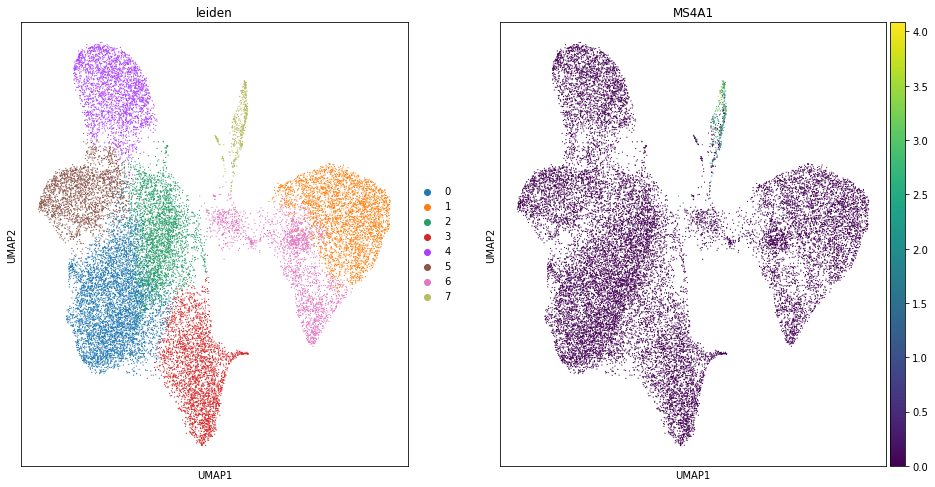

In [49]:
sc.tl.leiden(adata, resolution = .4)
sc.pl.umap(adata, color = ['leiden', 'MS4A1'])

In [64]:
test = adata.obs.bc[(adata.obs.orig == 'F6') & (adata.obs.leiden == '7')]
test.isin(df.BC).sum()

100

In [63]:
Counter(adata.obs.leiden == 7)

Counter({False: 21624})

In [33]:
Counter(adata.obs.map)

Counter({'False': 21487, 'True': 137})

In [30]:
adata.obs.head()

orig            bc  n_genes  n_counts leiden    map
F6_0   F6  AAAAAATTAAGA      548     869.0      7  False
F6_1   F6  AAAAACACAGAC      405     793.0      5  False
F6_2   F6  AAAAACCCTTTG      421     811.0      2  False
F6_3   F6  AAAAACCGATAC     1283    2360.0      3  False
F6_4   F6  AAAACCAATTCC      632    1287.0      5  False

... storing 'map' as categorical


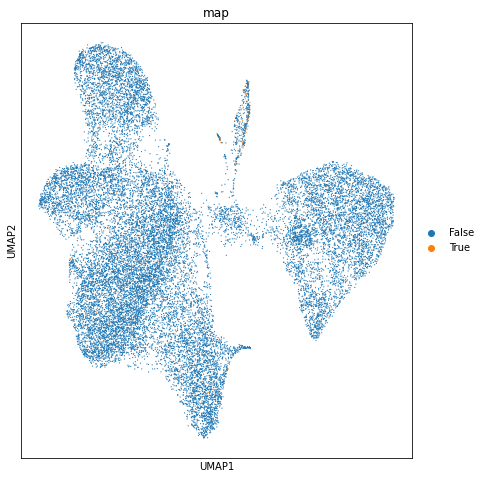

In [27]:
adata.obs.map = [str(x) for x in adata.obs.map]
sc.pl.umap(adata, color = 'map')

map      False     True 
orig                    
F6    0.983494  0.016506
F7    0.999442  0.000558
F8    0.998838  0.001162

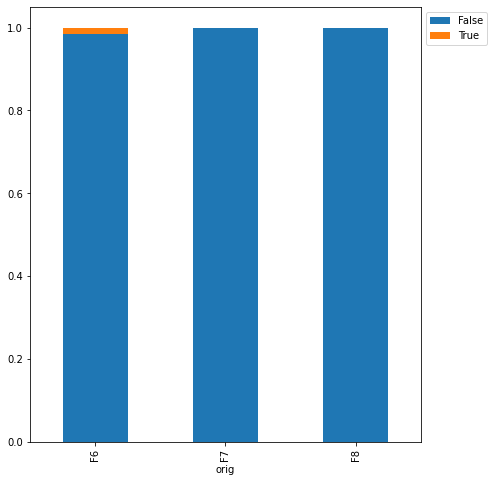

In [22]:
adata.obs['map'] = adata.obs.bc.isin(df.BC)
barplot(adata.obs, 'orig', 'map')

In [5]:
sc.tl.leiden(adata, resolution = .3)

NameError: name 'sc' is not defined

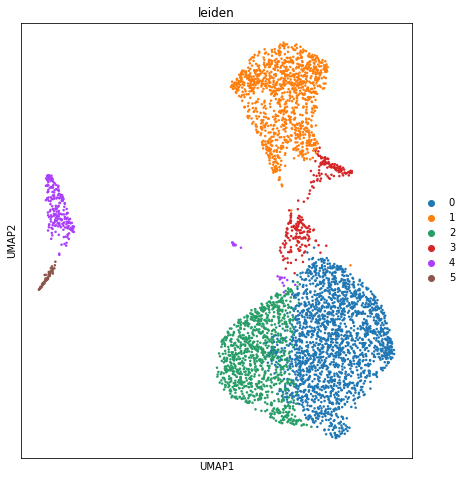

In [20]:
sc.pl.umap(adata, color = 'leiden')

KeyError: 'LOC703029'

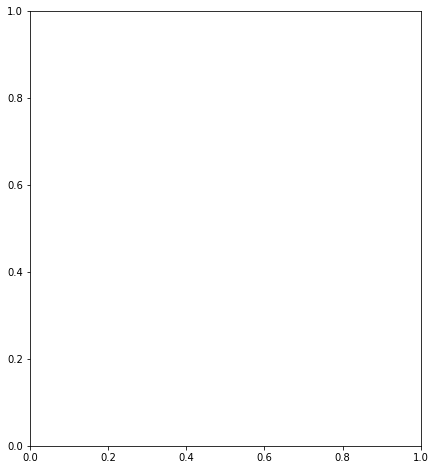

In [22]:
sc.pl.umap(adata, color = 'LOC703029')

In [21]:
adata.obs.to_csv('f3_meta.csv')